### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерироват стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [ ]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [ ]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [ ]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-12-05 12:32:29--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.004s  

2024-12-05 12:32:30 (57.1 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [ ]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


In [ ]:
print(tokens)

['\n', ' ', '!', '(', ')', ',', '-', '.', '5', '7', '8', '9', ':', ';', '?', '[', ']', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', '»', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', '–', '—', '’', '…', '€', '<sos>']


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [ ]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']


def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

array([83])

Пример батча:

In [ ]:
# (batch_size, seq_length + 1)
next(generate_chunk()).shape

(256, 101)

Далее вам предстоит написать код для обучения модели и генерации текста.

In [ ]:
# start_token = ""
start_token = "<sos>"
pad_token = " "

In [ ]:
# Example: cast 4 random names to matrices, pad with zeros
next_chunk = next(generate_chunk())


### RNN loop

Once we've defined a single RNN step, we can apply it in a loop to get predictions on each step.

In [ ]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """

    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)

        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)  # YOUR CODE HERE

        h_next = self.rnn_update(x_and_h)  # YOUR CODE HERE
        h_next = torch.tanh(h_next)  # YOUR CODE HERE

        assert h_next.size() == h_prev.size()

        # compute logits for next character probs
        logits = self.rnn_to_logits(h_next)  # YOUR CODE

        return h_next, logits

    def initial_state(self, batch_size):
        """return rnn state before it processes first input (aka h0)"""
        return torch.zeros(batch_size, self.num_units, requires_grad=True, device=device)



# your beautiful experiments here

In [ ]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    max_length, batch_size = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    all_logits = []

    for x_t in batch_ix:
        hid_state, logits_next = char_rnn(
            x_t, hid_state
        )  # <-- here we call your one-step code
        all_logits.append(logits_next)

    return torch.stack(all_logits, dim=1)

In [ ]:
char_rnn = CharRNNCell(num_tokens=len(tokens))

In [ ]:
batch_ix = next(generate_chunk())
print(f'{batch_ix=}')
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
print(f'{batch_ix.size()=}')

all_logits = rnn_loop(char_rnn, batch_ix)
print(f'{all_logits.size()=}')

batch_ix=array([[83, 48, 56, ..., 45, 57, 53],
       [83,  5,  0, ...,  5,  1, 52],
       [83, 58, 45, ..., 57, 53, 56],
       ...,
       [83, 61, 53, ...,  1, 60, 53],
       [83, 62, 73, ..., 46, 61, 45],
       [83, 51, 50, ..., 53, 57,  1]])
batch_ix.size()=torch.Size([256, 101])
all_logits.size()=torch.Size([101, 256, 84])


### Likelihood and gradients

We can now train our neural network to minimize crossentropy (maximize log-likelihood) with the actual next tokens.

To do so in a vectorized manner, we take `batch_ix[:, 1:]` - a matrix of token ids shifted i step to the left so i-th element is acutally the "next token" for i-th prediction

In [ ]:
# loss_func = nn.CrossEntropyLoss(ignore_index=token_to_idx[pad_token])
loss_func = nn.CrossEntropyLoss()
# (batch_size, max_length - 1)
actual_next_tokens = batch_ix[1:, :].T

# (batch_size, max_length-1, num_tokens)
pred_logits = all_logits[:, :-1, :]

pred_logits_flattened = pred_logits.reshape(
    (pred_logits.shape[0] * pred_logits.shape[1], -1)
)

actual_next_tokens_flattened = actual_next_tokens.reshape(-1)

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

### The training loop

We train our char-rnn exactly the same way we train any deep learning model: by minibatch sgd.

The only difference is that this time we sample strings, not images or sound.

In [ ]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell().to(device)
opt = torch.optim.Adam(char_rnn.parameters())
history = []

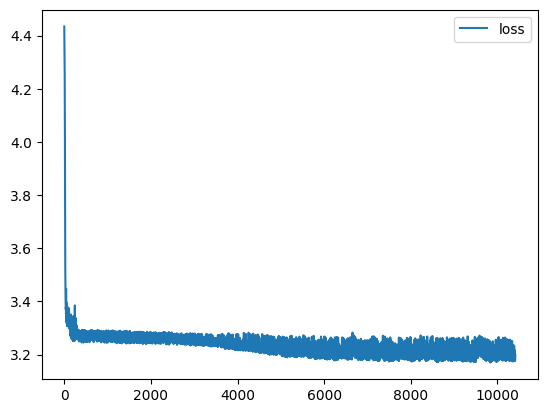

In [ ]:
epochs = 10000

for i in range(epochs):
    opt.zero_grad()
    # batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)`
    batch_ix = next(generate_chunk())
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64, device=device)

    all_logits = rnn_loop(char_rnn, batch_ix)

    # compute loss
    # <YOUR CODE>
    actual_next_tokens = batch_ix[1:, :].T

    pred_logits = all_logits[:, :-1, :]
    pred_logits_flattened = pred_logits.reshape(
        (pred_logits.shape[0] * pred_logits.shape[1], -1)
    )
    actual_next_tokens_flattened = actual_next_tokens.reshape(-1)
    loss = loss_func(pred_logits_flattened, actual_next_tokens_flattened)
    # train with backprop
    loss.backward()
    opt.step()
    # <YOUR CODE>

    history.append(loss.item())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
batch_ix.device

device(type='cuda', index=0)

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [ ]:
def generate_sample(char_rnn, seed_phrase: str= None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''


    if seed_phrase is not None:
        if seed_phrase.startswith(start_token):
            x_sequence = [token_to_idx[token] for token in seed_phrase]
        else:
            x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    #feed the seed phrase, if any

    # your code here

    hid_state = char_rnn.initial_state(batch_size=1).to(device)

    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    # start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits_next / temperature, dim=-1).data.cpu().numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [ ]:
print(generate_sample(char_rnn, ' мой дядя самых честных правил', max_length=500, temperature=0.5))

<sos> мой дядя самых честных правилиоешое
мнонендиоесаоетдееи
ерсеосватсдтоеипоолто
рноетпннаосв
рв
е
енуо
аейае
мемсеоиодноееотовемовняралвтнуоттолооинн
,тоуроиниечвготвраог.
еов
сарат

нсоыоониорао
нссонаиррлпсащ
ронриаиоьалонее
р
яеааатнн
иедсснтти
еоееемятезноненеоокеанлоед,елеееентнелиелеойтуориту
лояуоовьоуносоьоиопаеоао
но
ьон
аоноадрнсоинсоетнеиймоинант
мнвра
ооетноеоеерн
нте
ихнооатв,иирортзааааллвоартоонотиср,ееорыалоенменйиоон,о
втл,атооро,еиеораое,еовоавноееыоооисаиеитеспа
еоаеангон
.днло


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [ ]:
seed_phrase = ' мой дядя самых честных правил'

In [ ]:
# generated_phrases = # your code here

# For example:

generated_phrases = [
    generate_sample(
        char_rnn,
        ' мой дядя самых честных правил',
        max_length=500,
        temperature=1.
    ).replace('<sos>', '')
    for _ in range(10)
]

In [ ]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!